In [57]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchmetrics
from helper_functions import set_seeds
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torchinfo import summary
from torchvision import datasets, models, transforms


In [2]:
set_seeds(42)

In [10]:
image_path = Path("data/pizza_steak_sushi")

In [11]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [13]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [14]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


In [15]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [17]:
batch_size = 32
num_worker = os.cpu_count()

train_loader = DataLoader(
    train_dataset, batch_size=32, num_workers=num_worker, pin_memory=True, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, num_workers=num_worker, pin_memory=True, shuffle=True
)


In [34]:
classes = train_dataset.classes

In [18]:
weights = models.MobileNet_V2_Weights.DEFAULT
weights


MobileNet_V2_Weights.IMAGENET1K_V2

In [19]:
weights.transform()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [20]:
model = models.mobilenet_v2(weights)

d:\Users\Jordan\VS-CODE\learn\ml\learn-pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100.0%


In [25]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 112, 112]

In [31]:
for param in model.features.parameters():
    param.requires_grad = False


In [35]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=len(
            classes
        ),  # same number of output units as our number of classes
        bias=True,
    ),
)


In [36]:
summary(
    model,
    input_size=(
        32,
        3,
        224,
        224,
    ),  # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 1

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(classes))


In [47]:
def train(
    dataloader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    metric: torchmetrics.Metric,
):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        model.train()

        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y)
        acc = metric(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    final_acc = metric.compute()
    metric.reset()

    return final_acc.item()


In [48]:
def test(
    dataloader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    metric: torchmetrics.Metric,
):
    num_batches = len(dataloader)

    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            model.eval()

            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(y_logits, y).item()
            acc = metric(y_pred, y)

    final_acc = metric.compute()
    metric.reset()

    test_loss /= num_batches

    print(
        f"Test Error: \n Accuracy: {(100*final_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

    return final_acc.item()


In [49]:
epochs = 5

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_acc = train(train_loader, model, loss_fn, optimizer, metric)
    test_acc = test(test_loader, model, loss_fn, metric)


Epoch 1
-------------------------------
loss: 1.063085  [   32/  225]
Test Error: 
 Accuracy: 68.0%, Avg loss: 0.949510 

Epoch 2
-------------------------------
loss: 0.937044  [   32/  225]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.839342 

Epoch 3
-------------------------------
loss: 0.833687  [   32/  225]
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.800055 

Epoch 4
-------------------------------
loss: 0.759391  [   32/  225]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.717794 

Epoch 5
-------------------------------
loss: 0.690256  [   32/  225]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.721094 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


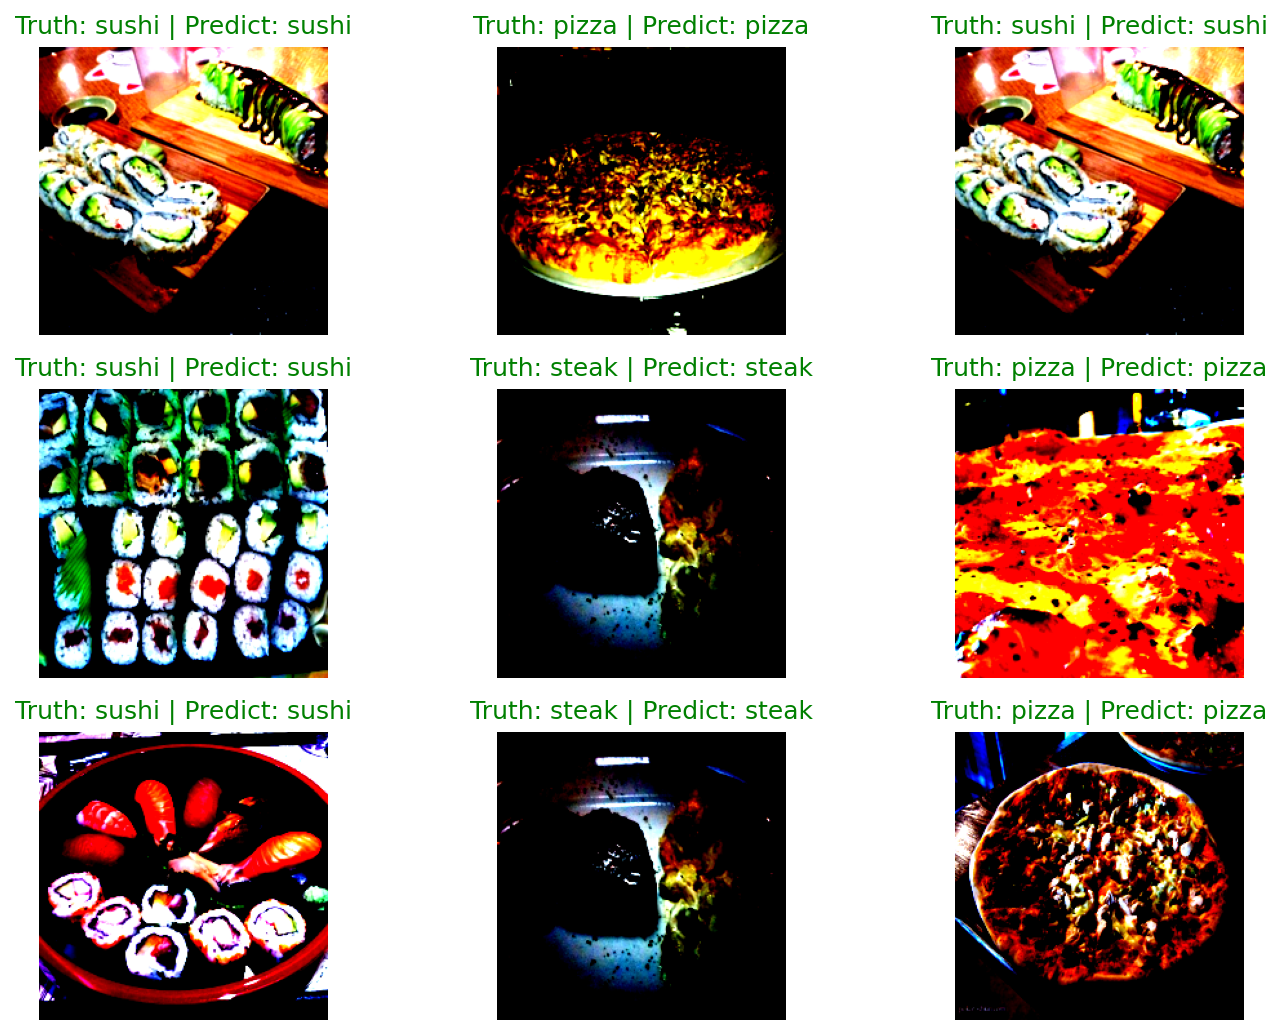

In [61]:
rows, cols = 3, 3
plt.figure(figsize=(10, 7), dpi=150)

model.eval()
for i, (X, y) in enumerate(random.choices(test_dataset, k=rows * cols)):
    plt.subplot(rows, cols, i + 1)

    with torch.inference_mode():
        y_pred = torch.softmax(model(X.unsqueeze(0)), 1).argmax(1)

    title = f"Truth: {classes[y]} | Predict: {classes[y_pred]}"

    plt.imshow(X.permute(1, 2, 0))

    if y == y_pred:
        plt.title(title, c="g")
    else:
        plt.title(title, c="r")
    plt.axis(False)

plt.tight_layout()
